In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import glob
import torch
import numpy as np
from torch import nn
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset

import logging
from importlib import reload  # Not needed in Python 2
reload(logging)

torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )



from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs


In [2]:
T = 24
batch_size = 2

# cfg = {'EM':'/AS_data/Emis_with_foreign_npy/EM_2015_*',
#       'label':'/AS_data/Conc_npy/PM25_2015_*',
#       'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
#       'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_*',
#       'METCRO3D':'',
#       'METCRO3D_5height':''}
cfg = {'EM':'/AS_data/Emis_npy/EM_2015_01*',
        'label':'/AS_data/Conc_npy/TOTAL_2015_01*',
        'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
        'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_01*',
        'METCRO3D':'',
        'METCRO3D_5height':''}

print('train data is loading ')
Data = AS_Data(cfg,left = 0,right = 0.75,window = T,pollution = ['PM25','O3'])
trainloader = DataLoader(Data,batch_size=batch_size,shuffle=True)
print(len(Data))

print('test data is loading ')
test_Data = AS_Data(cfg,left = 0.75,right = 1,window = T,pollution = ['PM25','O3'])
testloader = DataLoader(test_Data,batch_size=batch_size,shuffle=True)
print(len(test_Data))

train data is loading 
/AS_data/Conc_npy/TOTAL_2015_01_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_01_744_51_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_01_744_34_182_232.npy   is loading
534
test data is loading 
/AS_data/Conc_npy/TOTAL_2015_01_NO2_SO2_O3_PM25_PM10_CO__744_6_182_232.npy   is loading
/AS_data/Emis_npy/EM_2015_01_744_51_182_232.npy   is loading
/AS_data/METCRO2D_npy/METCRO2D_2015_01_744_34_182_232.npy   is loading
162


In [3]:
from model.res_model_LSTM import res8
from model.unet_model import UNet

test_model = res8(51+34,27,inplanes=64,layers = [2],T=T,pre_dim = 2) #+5*16
name = 'res'
# test_model = UNet(51+34,27,T=T,bilinear=False,pre_dim = 2) #+80
# name = 'unet2'
# test_model.load_state_dict(torch.load('model_save/o3_best_unet2_1month_65_epoch.t'))

test_model.to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(test_model.parameters(),lr=5e-3)


In [4]:
def score(model,loader,criterion= nn.L1Loss() ):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            input,grid,yt_1,label = i
            input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
            y_pred = model(input,grid,yt_1)
            
            cur_loss = []
            for j in range(label.shape[1]):
                loss = criterion(y_pred[:,j],label[:,j])
                cur_loss.append(loss.cpu().data)
            ls.append(cur_loss)
            
    return np.mean(np.array(ls),axis = 0)

In [ ]:
best_score = 1000
early_stop = 15
early_cnt = 0
for epoch in range(50):
    logging.info('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.train()
    for idx,i in enumerate(trainloader):
        input,grid,yt_1,label = i
        input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
        y_pred = test_model(input,grid,yt_1)

        y_pred = torch.squeeze(y_pred) #,dim = 2)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        if len(ls)%400==0:
            logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    
    logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    test_score_L1 = score(test_model,testloader,criterion = nn.L1Loss()) 
    logging.info('-------------cur test loss L1:  {}'.format(','.join([str(s) for s in test_score_L1])))
    
#     if epoch%5 == 0:
#         torch.save(test_model.cpu().state_dict(),'model_save/{}_{}_epoch.t'.format(name,epoch))
#         test_model.to(device)
    if np.sum(test_score_L1)<best_score:
        early_cnt = 0
        best_score = np.sum(test_score_L1)
        torch.save(test_model.cpu().state_dict(),'model_save/{}_best_epoch.t'.format(name))
        test_model.to(device)
    else:
        early_cnt += 1
        if early_cnt>=early_stop:
            break

In [46]:
r = []
for i in string.split('\n'):
    if 'test' in i:
        line = i.split(':  ')[-1][1:-1].split()
        r.append([float(j) for j in line])

In [47]:
r = np.array(r)

In [ ]:
for i in r[:,0]:
    print(i)

In [4]:
test_model.load_state_dict(torch.load('model_save/best_unet2_1month_60_epoch.t'))

# test_model = res8(51+34+16,27,[3],T=48)

test_model = test_model.to(device)

In [7]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def image_show(im,title = '',r=10,base=80):
#     im[:r,:r] = base
#     im[r,r] = 0
#     im[im>base] = base
    plt.title(title)
    plt.imshow(im[::-1],cmap=plt.cm.hot_r)
    plt.colorbar()
    plt.show()
    

In [1]:
import numpy as np

In [ ]:
a = np.load('/AS_data/Conc_npy/CO_2015_01_744_182_232.npy')
b = np.load('/AS_data/Conc_npy/O3_2015_01_744_182_232.npy')
c = np.load('/AS_data/Conc_npy/PM25_2015_01_744_182_232.npy')


In [4]:
dic = {'order':np.array([1,2,3,0]),'matrix':np.random.randn(3)}
np.save('test.npy',dic)

In [6]:
np.load('test.npy',allow_pickle=True)

array({'order': array([1, 2, 3, 0]), 'matrix': array([ 0.48764951, -0.04606721, -1.33232611])},
      dtype=object)

In [ ]:
1

In [ ]:
"NO2","SO2","O3","PM2.5","PM10","CO"

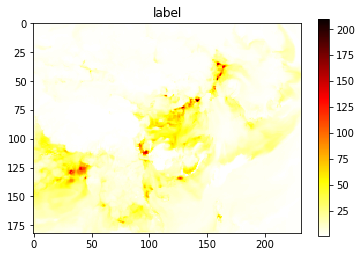

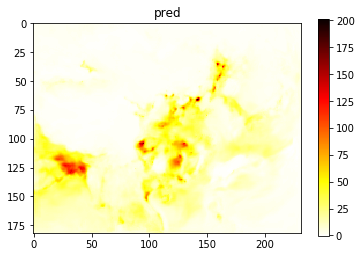

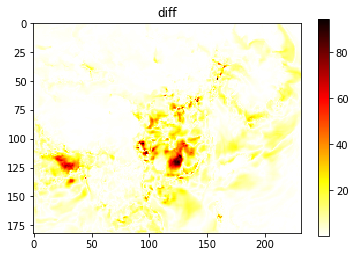

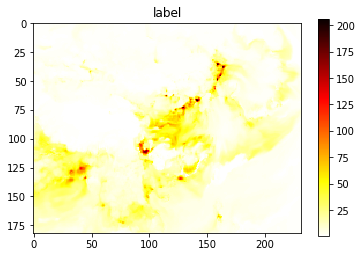

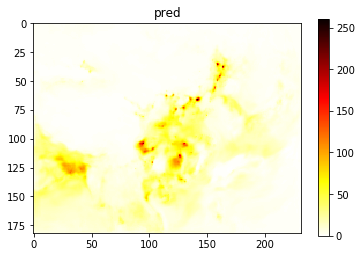

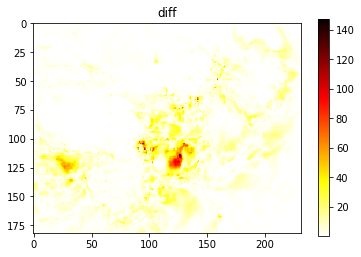

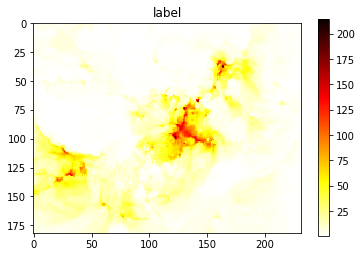

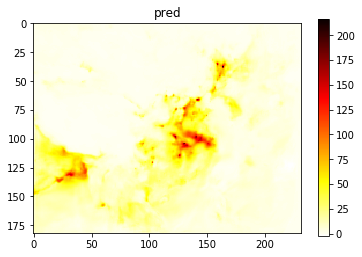

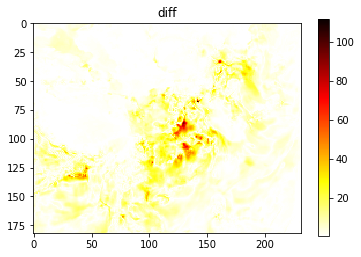

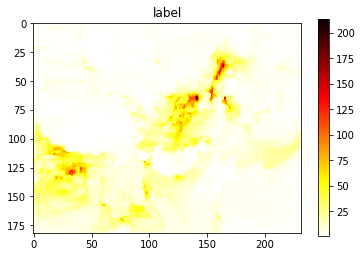

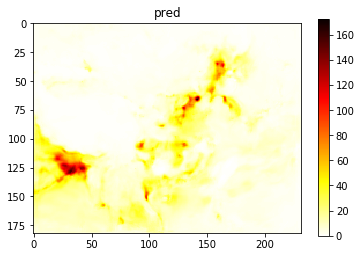

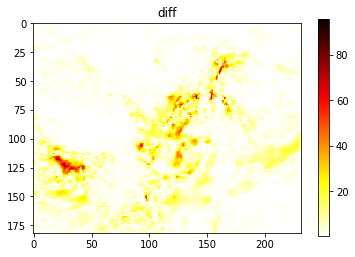

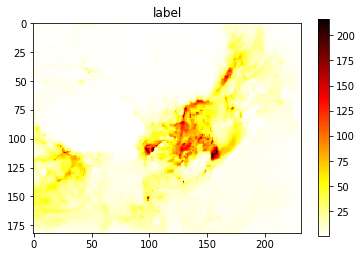

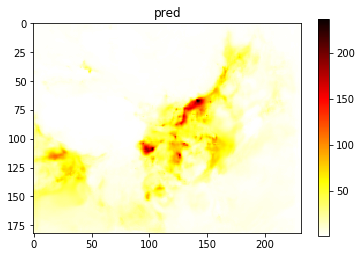

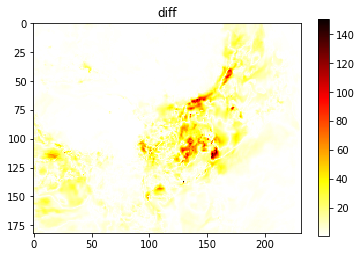

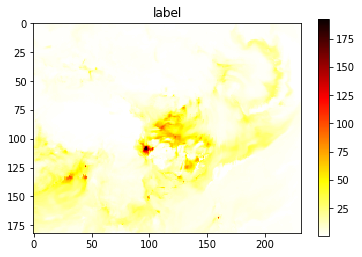

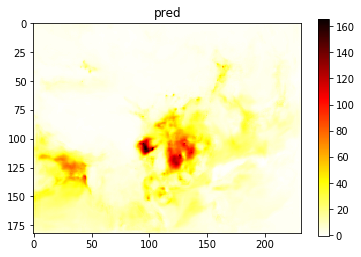

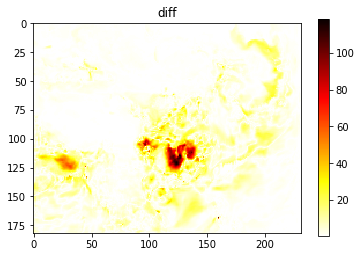

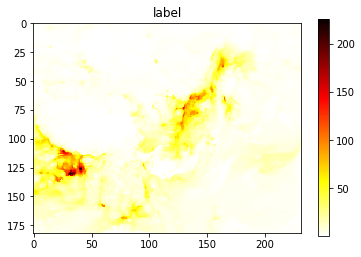

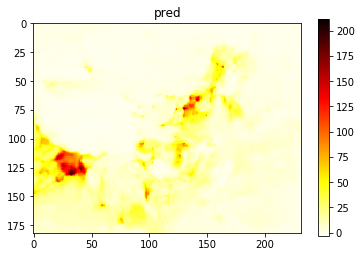

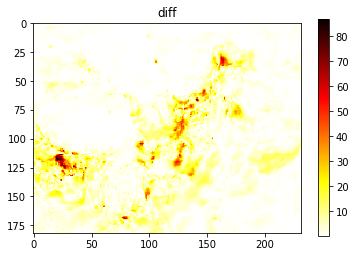

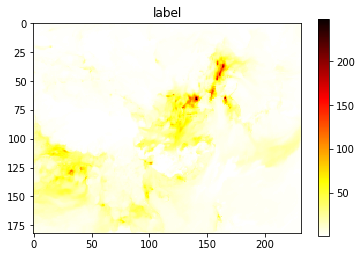

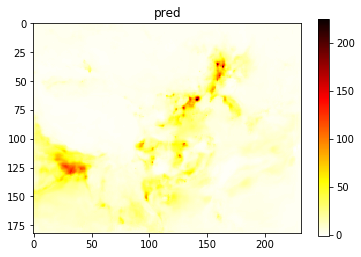

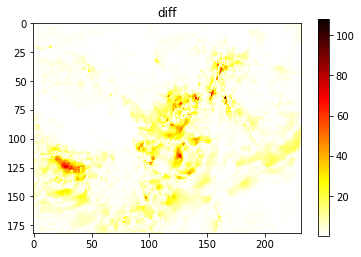

In [8]:
test_model.eval()
for idx,i in enumerate(testloader):
    with torch.no_grad():
        input,grid,yt_1,label = i
        input = torch.squeeze(input,1)
        yt_1 = torch.unsqueeze(yt_1,1)
        input,grid,yt_1,label = input.to(device),grid.to(device),yt_1.to(device),label.to(device)
        y_pred = test_model(input,grid,yt_1)
        
        y_pred = y_pred.squeeze(dim = 1)
        label = label.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        for b_idx in range(len(label)):
            image1 = label[b_idx]
            image_show(image1,'label')

            image2 = y_pred[b_idx]
            image_show(image2,'pred')
#             print(np.sum(y_pred[b_idx]>=label[b_idx]))

            image3 = np.abs(image2-image1)
            image_show(image3,'diff')
        
        break


In [8]:
import torch
a = torch.randn(4,4)


In [20]:
import numpy as np
labels = np.load('/AS_data/Conc_npy/O3_2015_01_744_182_232.npy')
for i in range(48):
    print(i,np.mean(np.abs(labels[i:]-labels[:744-i])))

0 0.0
1 1.2618659
2 2.4312294
3 3.4814103
4 4.410709
5 5.223562
6 5.925452
7 6.519802
8 7.0082893
9 7.3945417
10 7.684277
11 7.8876786
12 8.013739
13 8.067311
14 8.049162
15 7.957137
16 7.789321
17 7.548805
18 7.243804
19 6.887095
20 6.494405
21 6.086113
22 5.692797
23 5.371518
24 5.2505207
25 5.4928536
26 5.9270167
27 6.42115
28 6.920641
29 7.397266
30 7.83409
31 8.218925
32 8.541506
33 8.795923
34 8.981527
35 9.103271
36 9.166313
37 9.172544
38 9.120054
39 9.0044565
40 8.821548
41 8.573123
42 8.266353
43 7.9131913
44 7.5280457
45 7.130221
46 6.749429
47 6.4376616


torch.Size([2, 4, 4])

In [19]:
output = model(x,grid,yt_1)

In [16]:
output.shape

torch.Size([3, 1, 100, 200])

In [9]:
%debug

> /opt/conda/lib/python3.6/site-packages/torch/nn/modules/conv.py(340)conv2d_forward()
    338                             _pair(0), self.dilation, self.groups)
    339         return F.conv2d(input, weight, self.bias, self.stride,
--> 340                         self.padding, self.dilation, self.groups)
    341 
    342     def forward(self, input):



ipdb>  x.shape


*** NameError: name 'x' is not defined


ipdb>  u


> /opt/conda/lib/python3.6/site-packages/torch/nn/modules/conv.py(343)forward()
    341 
    342     def forward(self, input):
--> 343         return self.conv2d_forward(input, self.weight)
    344 
    345 class Conv3d(_ConvNd):



ipdb>  u


> /opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py(547)__call__()
    545             result = self._slow_forward(*input, **kwargs)
    546         else:
--> 547             result = self.forward(*input, **kwargs)
    548         for hook in self._forward_hooks.values():
    549             hook_result = hook(self, input, result)



ipdb>  u


> <ipython-input-5-39023183985d>(95)forward()
     93 
     94         x = x.reshape(B,-1,H,W) #B*C1*H*W
---> 95         x = self.conv_temporal(x) #B*C1*H*W  -> B*C2*H*W
     96 
     97         x = self.bn1(x)



ipdb>  x.shape


torch.Size([3, 512, 100, 200])


ipdb>  self.conv_temporal


Conv2d(1536, 64, kernel_size=(1, 1), stride=(1, 1))


ipdb>  q
